In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [236]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

## Reflect Tables into SQLALchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [15]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [16]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
inspector = inspect(engine)

In [17]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = Base.classes.measurement

# Get column names to assist with queries
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
Station = Base.classes.station

# Get column names to assist with queries
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [150]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

t = calc_temps('2017-08-01','2017-08-07')
tmin = t[0][0]
tavg = t[0][1]
tmax = t[0][2]

temps_df = pd.DataFrame({
        "TMIN": [tmin],
        "TAVG": [tavg],
        "TMAX": [tmax]   
})
temps_df.head()


,TMIN,TAVG,TMAX
0,72.0,79.25,83.0


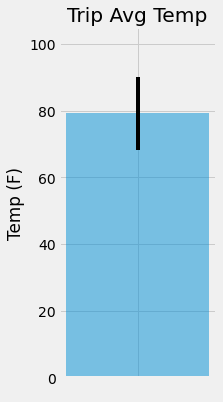

In [185]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2.5,6))
plt.bar(' ',tavg,yerr=(tmax-tmin),alpha=0.5,align="center")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(0,105)
plt.show()

### Daily Rainfall Average

In [222]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [func.sum(Measurement.prcp), Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
precips = session.query(*sel).filter(Measurement.station == Station.station).\
        filter(Measurement.prcp != 'None').\
        filter(Measurement.date >= '2017-08-01').\
        filter(Measurement.date <= '2017-08-07').\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
precips

[(0.36, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 (0.22, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (0.06, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (0.04, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]

In [246]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [286]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

    # Convert the date column format from string to datetime
start_date_dt = pd.to_datetime(start_date,format='%Y-%m-%d')
end_date_dt = pd.to_datetime(end_date,format='%Y-%m-%d')
daysdiff = end_date_dt - start_date_dt

# Use the start and end date to create a range of dates

# Strip off the year and save a list of strings in the format %m-%d

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.

normals_l = []
for d in range(daysdiff.days+1):
    date = start_date_dt + timedelta(days=d)
    date_conv = date.strftime('%m-%d')
    normals_l.append(daily_normals(date_conv))

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [294]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
session.close()